<a href="https://colab.research.google.com/github/jvalcour27/ML-5540-Project/blob/main/ML_5540_Final_Project_Code_Valcour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

In [40]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
import warnings
warnings.filterwarnings('ignore')

# Load, Clean, and Explore Data

In [42]:
df = pd.read_csv('/content/drive/My Drive/CS5540/Final-Project/Event_Data_for_Analysis.csv', sep=',',encoding='utf-8-sig', on_bad_lines='warn')
print("DataFrame columns :")
print(df.columns.tolist())

DataFrame columns :
['UNIQUE_ID', 'DATE', 'Year', 'BCode', 'CCODE1', 'CCODE2', 'NUMBER_OF_Countries', 'BAR_Scale', 'Issue_Type1', 'Issue_Cat']


In [43]:
# Get the list of column names (features)
features = df.columns.tolist()

# Display the list of features
print("List of features:")
print(features)

List of features:
['UNIQUE_ID', 'DATE', 'Year', 'BCode', 'CCODE1', 'CCODE2', 'NUMBER_OF_Countries', 'BAR_Scale', 'Issue_Type1', 'Issue_Cat']


In [44]:
#display first 5 rows
display(df.head())

,UNIQUE_ID,DATE,Year,BCode,CCODE1,CCODE2,NUMBER_OF_Countries,BAR_Scale,Issue_Type1,Issue_Cat
0,1,3/16/1948,1948.0,NILE,EGY,INT,1.0,Cooperation,3.0,hydro-power_electricity
1,2,4/1/1948,1948.0,INDU,IND,PAK,2.0,Conflict,2.0,Water Quantity
2,3,5/4/1948,1948.0,INDU,IND,PAK,2.0,Cooperation,2.0,Water Quantity
3,4,7/8/1948,1948.0,ROIA,FRA,ITA,2.0,Cooperation,10.0,Infrastructure_Development
4,5,7/30/1948,1948.0,DANU,CZS,GBR,8.0,CBDM,8.0,Joint_Management


In [45]:
df.info()
# Get descriptive statistics for all the columns in the DataFrame
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128 entries, 0 to 7127
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UNIQUE_ID            7128 non-null   int64  
 1   DATE                 7110 non-null   object 
 2   Year                 7110 non-null   float64
 3   BCode                7128 non-null   object 
 4   CCODE1               7077 non-null   object 
 5   CCODE2               7053 non-null   object 
 6   NUMBER_OF_Countries  6694 non-null   float64
 7   BAR_Scale            6805 non-null   object 
 8   Issue_Type1          7127 non-null   float64
 9   Issue_Cat            7127 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 557.0+ KB


,UNIQUE_ID,DATE,Year,BCode,CCODE1,CCODE2,NUMBER_OF_Countries,BAR_Scale,Issue_Type1,Issue_Cat
count,7128.000000,7110,7110.000000,7128,7077,7053,6694.000000,6805,7127.000000,7127
unique,NaN,3089,NaN,146,172,161,NaN,5,NaN,14
top,NaN,7/1/1992,NaN,DANU,IND,USA,NaN,CBDM,NaN,Water Quantity
freq,NaN,78,NaN,975,383,425,NaN,2796,NaN,1863
mean,2141.576319,NaN,1987.274824,NaN,NaN,NaN,4.394234,NaN,5.480006,NaN
std,1105.603236,NaN,15.887683,NaN,NaN,NaN,3.576377,NaN,3.817859,NaN
min,1.000000,NaN,1948.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN
25%,1310.750000,NaN,1975.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,NaN
50%,2226.000000,NaN,1993.000000,NaN,NaN,NaN,3.000000,NaN,5.000000,NaN
75%,3014.000000,NaN,1999.000000,NaN,NaN,NaN,5.000000,NaN,9.000000,NaN


## Preprocess the data

- Handle data type issues and missing Values
- Covert 'Year' to integer
- perform one-hot encoding
- define the list of columns to be dropped from the feature set.

In [46]:
# Drop rows with missing values in 'BAR_Scale', 'Issue_Cat', 'NUMBER_OF_Countries', 'BCode', or 'Year'
# these are the features for the analysis
df = df.dropna(subset=['BAR_Scale', 'Issue_Cat', 'NUMBER_OF_Countries', 'BCode', 'Year']).copy()

# Convert 'Year' column to integer type
df['Year'] = df['Year'].astype(int)

# Check for missing values again
print("Missing values:")
print(df[['BAR_Scale', 'Issue_Cat', 'NUMBER_OF_Countries', 'Year']].isnull().sum())

# Display the shape of the cleaned DataFrame
print("\nShape of the cleaned DataFrame:", df.shape)

Missing values:
BAR_Scale              0
Issue_Cat              0
NUMBER_OF_Countries    0
Year                   0
dtype: int64

Shape of the cleaned DataFrame: (6362, 10)


## One-Hot-Encode Issue_Cat, BCode, BAR_Scale

In [47]:
# Perform one-hot encoding on 'Issue_Cat', 'BCode', 'BAR_Scale'
df_encoded = pd.get_dummies(df, columns=['Issue_Cat', 'BCode', 'BAR_Scale'], prefix=['Issue_Cat', 'BCode', 'BAR_Scale'], dtype=int)

# Rename columns to replace whitespaces with underscores immediately after encoding
# df_encoded.columns = df_encoded.columns.str.replace(' ', '_')

# Display the first few rows of the encoded DataFrame
display(df_encoded.head())

# Display the shape of the encoded DataFrame
print("\nShape of the encoded DataFrame:", df_encoded.shape)

,UNIQUE_ID,DATE,Year,CCODE1,CCODE2,NUMBER_OF_Countries,Issue_Type1,Issue_Cat_Border_Issues,Issue_Cat_Economic_Development,Issue_Cat_Flood_Control_Relief,...,BCode_VUKS,BCode_YALU,BCode_YAQU,BCode_ZAMB,BCode_ZARM,BAR_Scale_CBDM,BAR_Scale_Conflict,BAR_Scale_Cooperation,BAR_Scale_Neutral,BAR_Scale_Skirmish
0,1,3/16/1948,1948,EGY,INT,1.0,3.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,4/1/1948,1948,IND,PAK,2.0,2.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,5/4/1948,1948,IND,PAK,2.0,2.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,7/8/1948,1948,FRA,ITA,2.0,10.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,7/30/1948,1948,CZS,GBR,8.0,8.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0



Shape of the encoded DataFrame: (6362, 170)


## Drop features that will not be used in the analysis

In [48]:
# create a variable that lists features to drop:
# 'DATE', 'UNIQUE_ID', 'Issue_Type1', and CODE1' and 'CCODE2 (for now)
# we may want to use them later
columns_to_drop_from_X = ['DATE', 'UNIQUE_ID', 'Issue_Type1', 'CCODE1', 'CCODE2']

## Split Data into Training and Test Sets

In [49]:
# Define the year for splitting training data from validation/test data
training_cutoff_year = 1999

# Identify BAR_Scale (target) columns after one-hot encoding
# BAR_Scale_3C is not one-hot encoded (it's a categorical column with 3 values),
# so it should be excluded from the target variables.
bar_scale_target_cols = [col for col in df_encoded.columns if col.startswith('BAR_Scale_') ]

# Define the new column names for the target variables.
# Drop "Bar Scale" from all the encoded names.
y_cols_renamed = [col.replace('BAR_Scale_', '') for col in bar_scale_target_cols]

# Combine the columns to drop from features (X) with the target columns
# The target columns must be dropped from X to prevent target leakage.
# 'BAR_Scale' is the original categorical column and should also be dropped.
all_columns_to_drop_from_X = columns_to_drop_from_X + bar_scale_target_cols + ['BAR_Scale']

# Split data based on year for training and remaining (validation + test)
df_train = df_encoded[df_encoded['Year'] <= training_cutoff_year].copy()
df_remaining = df_encoded[df_encoded['Year'] > training_cutoff_year].copy()

# Split the remaining data into validation and test sets (50/50 split to match existing cell outputs)from sklearn.model_selection import train_test_split
df_validation, df_test = train_test_split(df_remaining, test_size=0.5, random_state=27, shuffle=True)

# Define X and y for training, validation, and test sets
X_train = df_train.drop(columns=all_columns_to_drop_from_X, errors='ignore')
y_train_recode = df_train[bar_scale_target_cols].copy()
y_train_recode.columns = y_cols_renamed

X_val = df_validation.drop(columns=all_columns_to_drop_from_X, errors='ignore')
y_val_recode = df_validation[bar_scale_target_cols].copy()
y_val_recode.columns = y_cols_renamed

X_test = df_test.drop(columns=all_columns_to_drop_from_X, errors='ignore')
y_test_recode = df_test[bar_scale_target_cols].copy()
y_test_recode.columns = y_cols_renamed

print("Data splitting complete.")

Data splitting complete.


In [50]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train_recode:", y_train_recode.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test_recode:", y_test_recode.shape)

Shape of X_train: (5232, 160)
Shape of y_train_recode: (5232, 5)
Shape of X_test: (565, 160)
Shape of y_test_recode: (565, 5)


# Analysis

This code will train and evaluate four machine learning classifiers (Random Forest, SVM, LightGBM, and XGBoost) on the dataset.

For each model, the code will run a classification report and accuracy score on the test set.

The code will compare the performance of all models through a summary table and a bar chart.

The target features are the Bar_Scale one-hot-encoded features


--- Training Random Forest Classifier ---
Random Forest Accuracy: 0.3770
Random Forest Classification Report:
              precision    recall  f1-score   support

        CBDM       0.51      0.55      0.53       258
    Conflict       0.00      0.00      0.00        11
 Cooperation       0.34      0.22      0.26       124
     Neutral       0.00      0.00      0.00        19
    Skirmish       0.48      0.29      0.37       153

   micro avg       0.47      0.38      0.42       565
   macro avg       0.27      0.21      0.23       565
weighted avg       0.44      0.38      0.40       565
 samples avg       0.38      0.38      0.38       565


--- Training SVC ---
SVC Accuracy: 0.1717
SVC Classification Report:
              precision    recall  f1-score   support

        CBDM       0.57      0.29      0.38       258
    Conflict       0.00      0.00      0.00        11
 Cooperation       0.28      0.28      0.28       124
     Neutral       0.00      0.00      0.00        19
    S

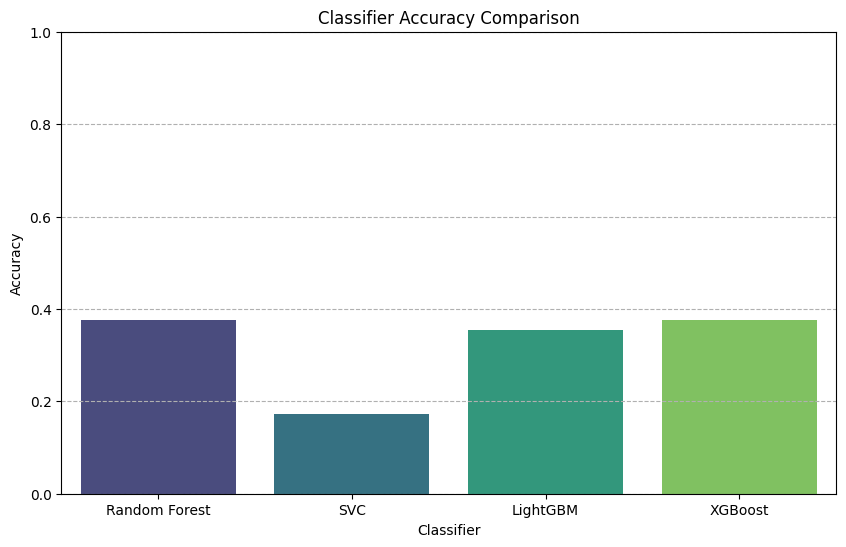

In [51]:
# Dictionary to store model performance
model_performance = {}

# Random Forest Classifier
print("\n--- Training Random Forest Classifier ---")
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=27))
rf_classifier.fit(X_train, y_train_recode)
y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test_recode, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test_recode, y_pred_rf, target_names=y_cols_renamed, zero_division=0))
model_performance['Random Forest'] = {'Accuracy': accuracy_rf}

# --- Support Vector Classifier (SVC) ---
print("\n--- Training SVC ---")
svc_classifier = MultiOutputClassifier(SVC(kernel='linear', C=1.0, random_state=27))
svc_classifier.fit(X_train, y_train_recode)
y_pred_svc = svc_classifier.predict(X_test)

accuracy_svc = accuracy_score(y_test_recode, y_pred_svc)
print(f"SVC Accuracy: {accuracy_svc:.4f}")
print("SVC Classification Report:")
print(classification_report(y_test_recode, y_pred_svc, target_names=y_cols_renamed, zero_division=0))
model_performance['SVC'] = {'Accuracy': accuracy_svc}

# --- LightGBM Classifier ---
print("\n--- Training LightGBM Classifier ---")
lgbm_classifier = MultiOutputClassifier(lgb.LGBMClassifier(objective='binary', random_state=27))
lgbm_classifier.fit(X_train, y_train_recode)
y_pred_lgbm = lgbm_classifier.predict(X_test)

accuracy_lgbm = accuracy_score(y_test_recode, y_pred_lgbm)
print(f"LightGBM Accuracy: {accuracy_lgbm:.4f}")
print("LightGBM Classification Report:")
print(classification_report(y_test_recode, y_pred_lgbm, target_names=y_cols_renamed, zero_division=0))
model_performance['LightGBM'] = {'Accuracy': accuracy_lgbm}

# --- XGBoost Classifier ---
print("\n--- Training XGBoost Classifier ---")
xgb_classifier = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=27))
xgb_classifier.fit(X_train, y_train_recode)
y_pred_xgb = xgb_classifier.predict(X_test)

accuracy_xgb = accuracy_score(y_test_recode, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print("XGBoost Classification Report:")
print(classification_report(y_test_recode, y_pred_xgb, target_names=y_cols_renamed, zero_division=0))
model_performance['XGBoost'] = {'Accuracy': accuracy_xgb}

# --- Summary Table ---
print("\n--- Model Performance Summary ---")
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
print(performance_df)

# --- Bar Chart of Accuracies ---
plt.figure(figsize=(10, 6))
sns.barplot(x=performance_df.index, y='Accuracy', data=performance_df, palette='viridis')
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--')
plt.show()

## Accuracy vs. Number of Estimators



Evaluating XGBoost accuracy for different n_estimators...
Training XGBoost with n_estimators=50...
Accuracy with n_estimators=50: 0.3805
Training XGBoost with n_estimators=100...
Accuracy with n_estimators=100: 0.3752
Training XGBoost with n_estimators=150...
Accuracy with n_estimators=150: 0.3558
Training XGBoost with n_estimators=200...
Accuracy with n_estimators=200: 0.3522
Training XGBoost with n_estimators=250...
Accuracy with n_estimators=250: 0.3575
Training XGBoost with n_estimators=300...
Accuracy with n_estimators=300: 0.3575


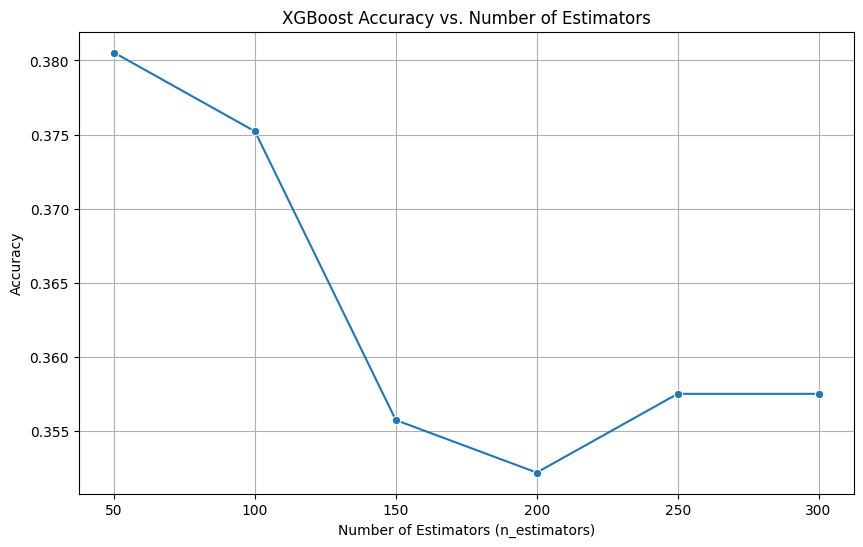

XGBoost n_estimators tuning complete.


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

n_estimators_range = range(50, 301, 50) # Test n_estimators from 50 to 300
accuracies = []

print("Evaluating XGBoost accuracy for different n_estimators...")

for n_est in n_estimators_range:
    print(f"Training XGBoost with n_estimators={n_est}...")
    xgb_tuned_classifier = MultiOutputClassifier(xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=27,
        n_estimators=n_est # Set the current number of estimators
    ))
    xgb_tuned_classifier.fit(X_train, y_train_recode)
    y_pred_tuned_xgb = xgb_tuned_classifier.predict(X_test)

    current_accuracy = accuracy_score(y_test_recode, y_pred_tuned_xgb)
    accuracies.append(current_accuracy)
    print(f"Accuracy with n_estimators={n_est}: {current_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_estimators_range), y=accuracies, marker='o')
plt.title('XGBoost Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(list(n_estimators_range))
plt.show()

print("XGBoost n_estimators tuning complete.")

## Generate Accuracy vs. Estimators Graph for Random Forest



Evaluating Random Forest accuracy for different n_estimators...
Training Random Forest with n_estimators=50...
Accuracy with n_estimators=50: 0.2867
Training Random Forest with n_estimators=100...
Accuracy with n_estimators=100: 0.3770
Training Random Forest with n_estimators=150...
Accuracy with n_estimators=150: 0.2920
Training Random Forest with n_estimators=200...
Accuracy with n_estimators=200: 0.3398
Training Random Forest with n_estimators=250...
Accuracy with n_estimators=250: 0.3097
Training Random Forest with n_estimators=300...
Accuracy with n_estimators=300: 0.3097


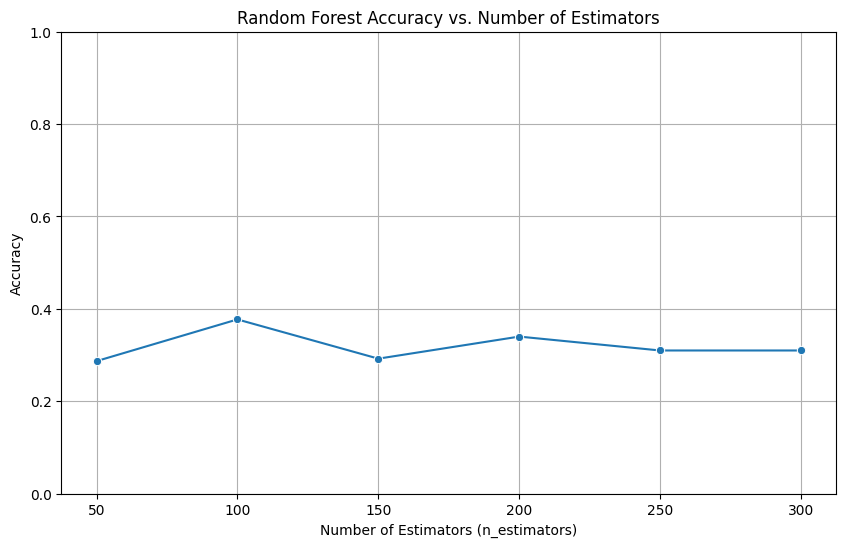

Random Forest n_estimators tuning complete.


In [53]:
n_estimators_range = range(50, 301, 50)
rf_accuracies = []

print("Evaluating Random Forest accuracy for different n_estimators...")

for n_est in n_estimators_range:
    print(f"Training Random Forest with n_estimators={n_est}...")
    rf_tuned_classifier = MultiOutputClassifier(RandomForestClassifier(
        n_estimators=n_est,
        random_state=27,
    ))
    rf_tuned_classifier.fit(X_train, y_train_recode)
    y_pred_tuned_rf = rf_tuned_classifier.predict(X_test)

    current_accuracy = accuracy_score(y_test_recode, y_pred_tuned_rf)
    rf_accuracies.append(current_accuracy)
    print(f"Accuracy with n_estimators={n_est}: {current_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_estimators_range), y=rf_accuracies, marker='o')
plt.title('Random Forest Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(True)
plt.xticks(list(n_estimators_range))
plt.show()

print("Random Forest n_estimators tuning complete.")

Evaluating LightGBM accuracy for different n_estimators...
Training LightGBM with n_estimators=50...
Accuracy with n_estimators=50: 0.3752
Training LightGBM with n_estimators=100...
Accuracy with n_estimators=100: 0.3540
Training LightGBM with n_estimators=150...
Accuracy with n_estimators=150: 0.3504
Training LightGBM with n_estimators=200...
Accuracy with n_estimators=200: 0.3522
Training LightGBM with n_estimators=250...
Accuracy with n_estimators=250: 0.3257
Training LightGBM with n_estimators=300...
Accuracy with n_estimators=300: 0.3168


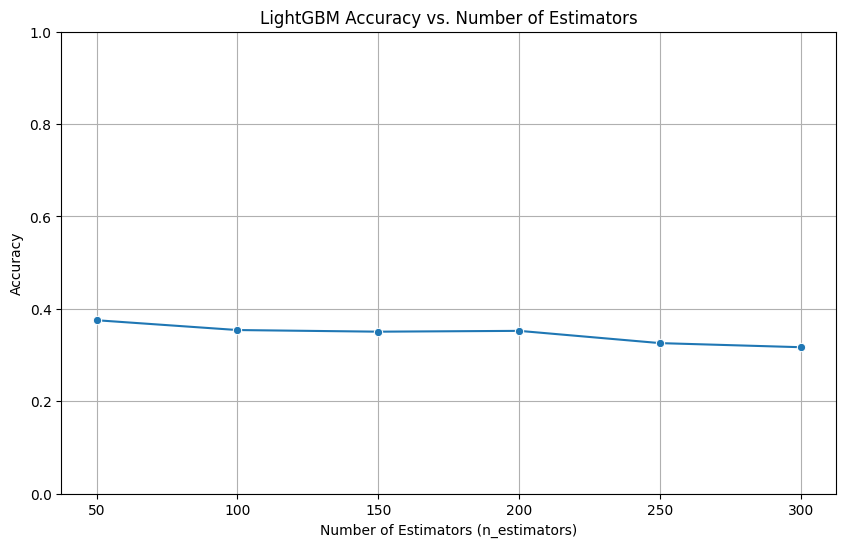

LightGBM n_estimators tuning complete.


In [54]:
n_estimators_range = range(50, 301, 50) # Test n_estimators from 50 to 300
lgbm_accuracies = []

print("Evaluating LightGBM accuracy for different n_estimators...")

for n_est in n_estimators_range:
    print(f"Training LightGBM with n_estimators={n_est}...")
    lgbm_tuned_classifier = MultiOutputClassifier(lgb.LGBMClassifier(
        objective='binary',
        random_state=27,
        n_estimators=n_est, # Set the current number of estimators
        verbose=-1 # Suppress LightGBM informational output
    ))
    lgbm_tuned_classifier.fit(X_train, y_train_recode)
    y_pred_tuned_lgbm = lgbm_tuned_classifier.predict(X_test)

    current_accuracy = accuracy_score(y_test_recode, y_pred_tuned_lgbm)
    lgbm_accuracies.append(current_accuracy)
    print(f"Accuracy with n_estimators={n_est}: {current_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_estimators_range), y=lgbm_accuracies, marker='o')
plt.title('LightGBM Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(True)
plt.xticks(list(n_estimators_range))
plt.show()

print("LightGBM n_estimators tuning complete.")

Evaluating LightGBM accuracy for different n_estimators...
Training LightGBM with n_estimators=50...
Accuracy with n_estimators=50: 0.3752
Training LightGBM with n_estimators=100...
Accuracy with n_estimators=100: 0.3540
Training LightGBM with n_estimators=150...
Accuracy with n_estimators=150: 0.3504
Training LightGBM with n_estimators=200...
Accuracy with n_estimators=200: 0.3522
Training LightGBM with n_estimators=250...
Accuracy with n_estimators=250: 0.3257
Training LightGBM with n_estimators=300...
Accuracy with n_estimators=300: 0.3168


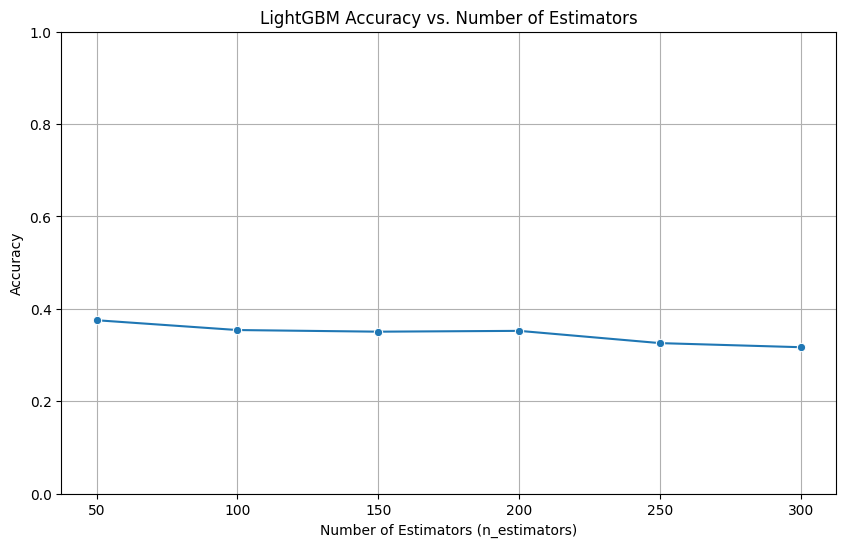

LightGBM n_estimators tuning complete.


In [55]:
n_estimators_range = range(50, 301, 50) # Test n_estimators from 50 to 300
lgbm_accuracies = []

print("Evaluating LightGBM accuracy for different n_estimators...")

for n_est in n_estimators_range:
    print(f"Training LightGBM with n_estimators={n_est}...")
    lgbm_tuned_classifier = MultiOutputClassifier(lgb.LGBMClassifier(
        objective='binary',
        random_state=27,
        n_estimators=n_est, # Set the current number of estimators
        verbose=-1 # Suppress LightGBM informational output
    ))
    lgbm_tuned_classifier.fit(X_train, y_train_recode)
    y_pred_tuned_lgbm = lgbm_tuned_classifier.predict(X_test)

    current_accuracy = accuracy_score(y_test_recode, y_pred_tuned_lgbm)
    lgbm_accuracies.append(current_accuracy)
    print(f"Accuracy with n_estimators={n_est}: {current_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_estimators_range), y=lgbm_accuracies, marker='o')
plt.title('LightGBM Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(True)
plt.xticks(list(n_estimators_range))
plt.show()

print("LightGBM n_estimators tuning complete.")

# ROC Curves


## ROC Curve for LightGB

LightGBM - Category: CBDM, AUC = 0.61
LightGBM - Category: Conflict, AUC = 0.67
LightGBM - Category: Cooperation, AUC = 0.56
LightGBM - Category: Neutral, AUC = 0.41
LightGBM - Category: Skirmish, AUC = 0.75


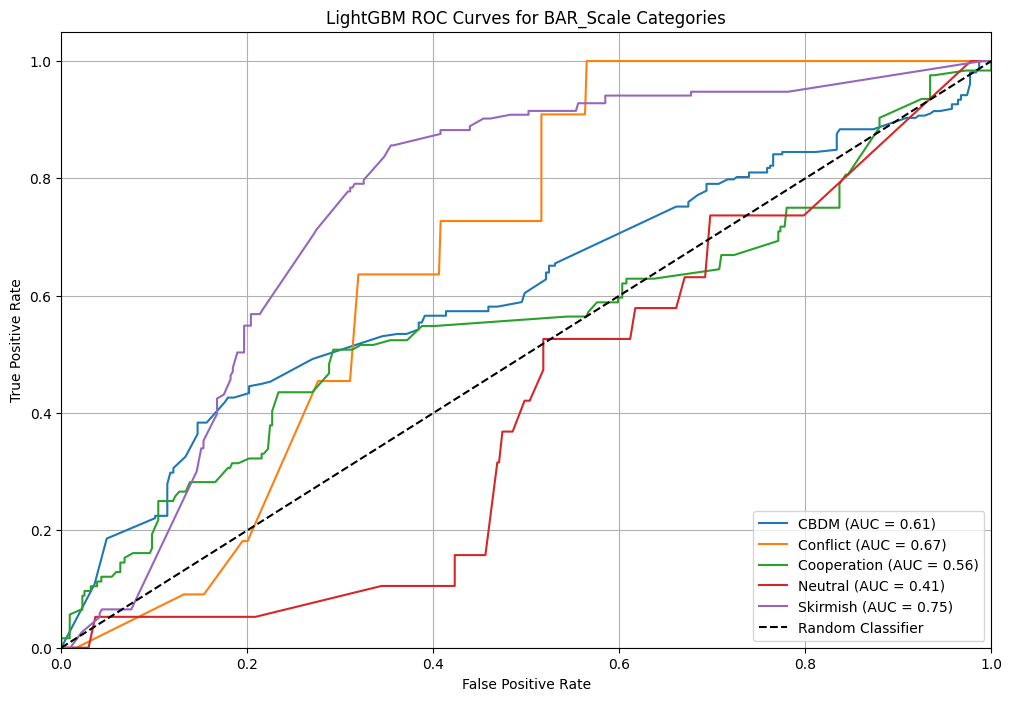

In [56]:
from sklearn.metrics import roc_curve, auc

y_pred_proba_lgbm = lgbm_classifier_tuned.predict_proba(X_test)
positive_class_probabilities = [y_proba[:, 1] for y_proba in y_pred_proba_lgbm]

plt.figure(figsize=(12, 8))

for i, category in enumerate(y_cols_renamed):
    y_true_category = y_test_recode[category]
    y_proba_category = positive_class_probabilities[i]
    fpr, tpr, thresholds = roc_curve(y_true_category, y_proba_category)
    roc_auc = auc(fpr, tpr)
    print(f"LightGBM - Category: {category}, AUC = {roc_auc:.2f}") # Print AUC here
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')

# Add random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('LightGBM ROC Curves for BAR_Scale Categories')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## ROC Curves for XGBoost


XGBoost - Category: CBDM, AUC = 0.61
XGBoost - Category: Conflict, AUC = 0.74
XGBoost - Category: Cooperation, AUC = 0.56
XGBoost - Category: Neutral, AUC = 0.50
XGBoost - Category: Skirmish, AUC = 0.77


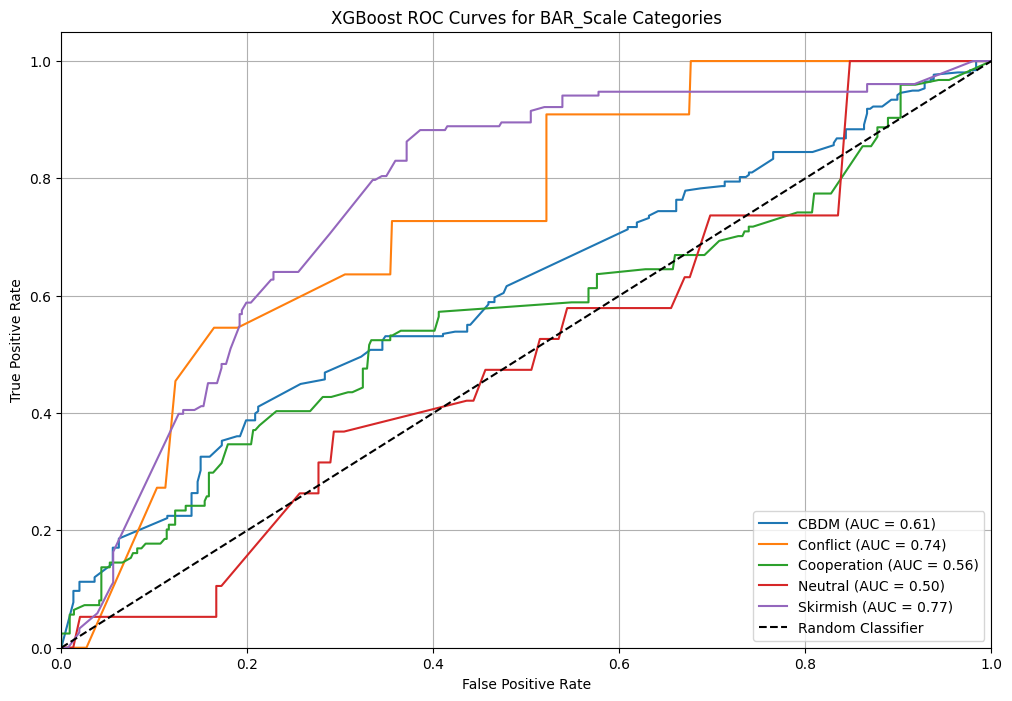

In [57]:
from sklearn.metrics import roc_curve, auc

y_pred_proba_xgb = xgb_classifier_tuned.predict_proba(X_test)

positive_class_probabilities_xgb = [y_proba[:, 1] for y_proba in y_pred_proba_xgb]

plt.figure(figsize=(12, 8))

for i, category in enumerate(y_cols_renamed):

    y_true_category = y_test_recode[category]
    y_proba_category = positive_class_probabilities_xgb[i]
    fpr, tpr, thresholds = roc_curve(y_true_category, y_proba_category)
    roc_auc = auc(fpr, tpr)
    print(f"XGBoost - Category: {category}, AUC = {roc_auc:.2f}") # Print AUC here
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('XGBoost ROC Curves for BAR_Scale Categories')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## ROC Curve for Random Forest

Random Forest - Category: CBDM, AUC = 0.58
Random Forest - Category: Conflict, AUC = 0.64
Random Forest - Category: Cooperation, AUC = 0.64
Random Forest - Category: Neutral, AUC = 0.33
Random Forest - Category: Skirmish, AUC = 0.69


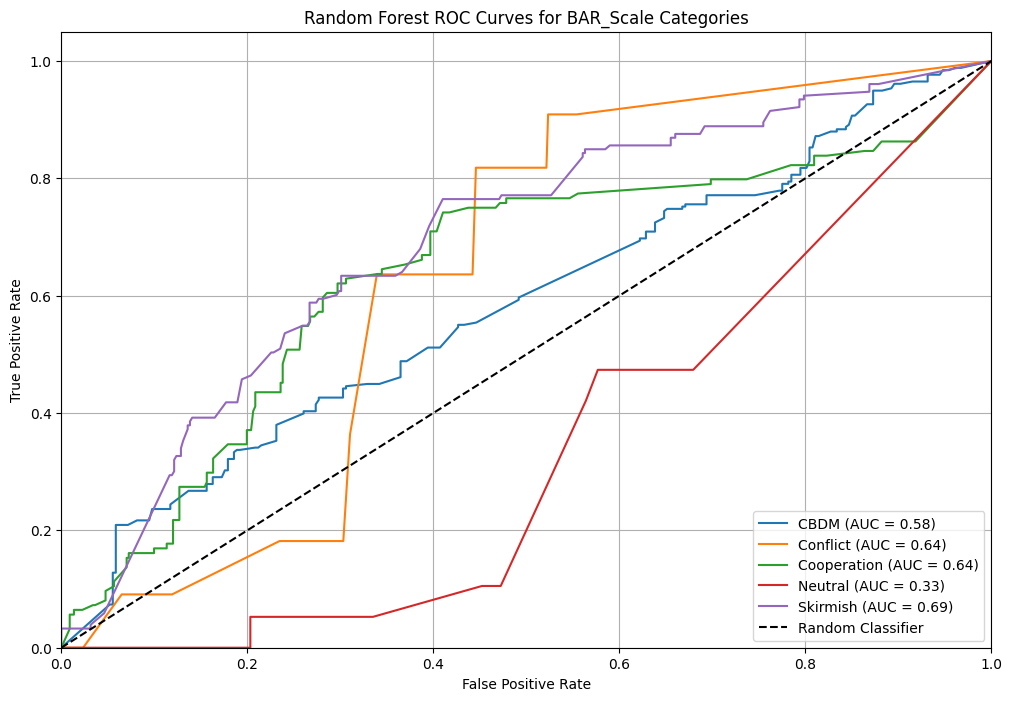

In [58]:
y_pred_proba_rf = rf_classifier_tuned.predict_proba(X_test)

positive_class_probabilities_rf = [y_proba[:, 1] for y_proba in y_pred_proba_rf]

plt.figure(figsize=(12, 8))

for i, category in enumerate(y_cols_renamed):
    y_true_category = y_test_recode[category]
    y_proba_category = positive_class_probabilities_rf[i]
    fpr, tpr, thresholds = roc_curve(y_true_category, y_proba_category)
    roc_auc = auc(fpr, tpr)
    print(f"Random Forest - Category: {category}, AUC = {roc_auc:.2f}") # Print AUC here
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('Random Forest ROC Curves for BAR_Scale Categories')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Analysis After Tuning the number of estimators





--- Training Random Forest Classifier (After Tuning) ---
Random Forest Accuracy (After Tuning): 0.3770
Random Forest Classification Report (After Tuning):
              precision    recall  f1-score   support

        CBDM       0.51      0.55      0.53       258
    Conflict       0.00      0.00      0.00        11
 Cooperation       0.34      0.22      0.26       124
     Neutral       0.00      0.00      0.00        19
    Skirmish       0.48      0.29      0.37       153

   micro avg       0.47      0.38      0.42       565
   macro avg       0.27      0.21      0.23       565
weighted avg       0.44      0.38      0.40       565
 samples avg       0.38      0.38      0.38       565


--- Training SVC (After Tuning) ---
SVC Accuracy (After Tuning): 0.1717
SVC Classification Report (After Tuning):
              precision    recall  f1-score   support

        CBDM       0.57      0.29      0.38       258
    Conflict       0.00      0.00      0.00        11
 Cooperation       0.28

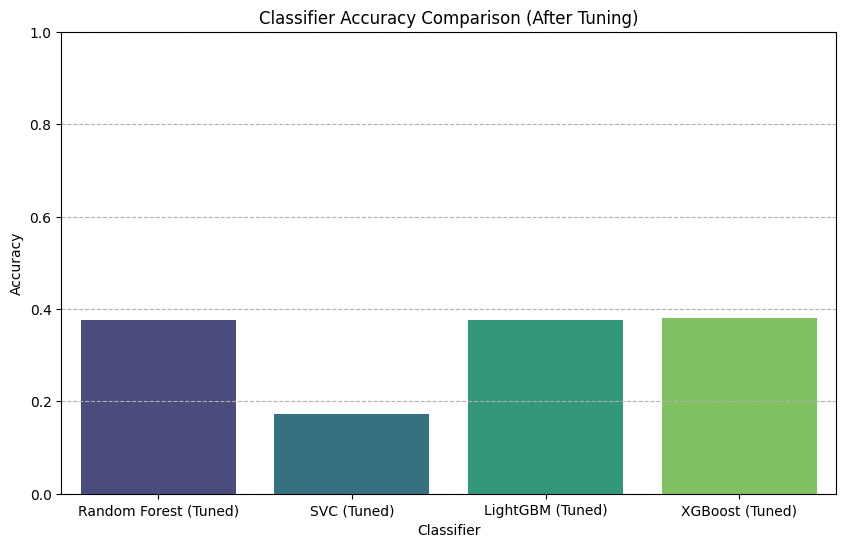

In [59]:
# Dictionary to store model performance for the tuned run
model_performance_tuned = {}

# --- Random Forest Classifier ---
print("\n--- Training Random Forest Classifier (After Tuning) ---")
# Keeping n_estimators=100 as it was optimal in tuning (and already used)
rf_classifier_tuned = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=27))
rf_classifier_tuned.fit(X_train, y_train_recode)
y_pred_rf_tuned = rf_classifier_tuned.predict(X_test)

accuracy_rf_tuned = accuracy_score(y_test_recode, y_pred_rf_tuned)
print(f"Random Forest Accuracy (After Tuning): {accuracy_rf_tuned:.4f}")
print("Random Forest Classification Report (After Tuning):")
print(classification_report(y_test_recode, y_pred_rf_tuned, target_names=y_cols_renamed, zero_division=0))
model_performance_tuned['Random Forest (Tuned)'] = {'Accuracy': accuracy_rf_tuned}

# --- Support Vector Classifier (SVC) ---
print("\n--- Training SVC (After Tuning) ---")
# SVC does not have n_estimators, so parameters remain the same
svc_classifier_tuned = MultiOutputClassifier(SVC(kernel='linear', C=1.0, random_state=27))
svc_classifier_tuned.fit(X_train, y_train_recode)
y_pred_svc_tuned = svc_classifier_tuned.predict(X_test)

accuracy_svc_tuned = accuracy_score(y_test_recode, y_pred_svc_tuned)
print(f"SVC Accuracy (After Tuning): {accuracy_svc_tuned:.4f}")
print("SVC Classification Report (After Tuning):")
print(classification_report(y_test_recode, y_pred_svc_tuned, target_names=y_cols_renamed, zero_division=0))
model_performance_tuned['SVC (Tuned)'] = {'Accuracy': accuracy_svc_tuned}

# --- LightGBM Classifier ---
print("\n--- Training LightGBM Classifier (After Tuning) ---")
# Adjusting n_estimators to 50 as identified in tuning, and suppressing verbose output
lgbm_classifier_tuned = MultiOutputClassifier(lgb.LGBMClassifier(objective='binary', random_state=27, n_estimators=50, verbose=-1))
lgbm_classifier_tuned.fit(X_train, y_train_recode)
y_pred_lgbm_tuned = lgbm_classifier_tuned.predict(X_test)

accuracy_lgbm_tuned = accuracy_score(y_test_recode, y_pred_lgbm_tuned)
print(f"LightGBM Accuracy (After Tuning): {accuracy_lgbm_tuned:.4f}")
print("LightGBM Classification Report (After Tuning):")
print(classification_report(y_test_recode, y_pred_lgbm_tuned, target_names=y_cols_renamed, zero_division=0))
model_performance_tuned['LightGBM (Tuned)'] = {'Accuracy': accuracy_lgbm_tuned}

# --- XGBoost Classifier ---
print("\n--- Training XGBoost Classifier (After Tuning) ---")
# adjusting n_estimators to 50 as identified in tuning, and suppressing verbose output
xgb_classifier_tuned = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=27, n_estimators=50))
xgb_classifier_tuned.fit(X_train, y_train_recode)
y_pred_xgb_tuned = xgb_classifier_tuned.predict(X_test)

accuracy_xgb_tuned = accuracy_score(y_test_recode, y_pred_xgb_tuned)
print(f"XGBoost Accuracy (After Tuning): {accuracy_xgb_tuned:.4f}")
print("XGBoost Classification Report (After Tuning):")
print(classification_report(y_test_recode, y_pred_xgb_tuned, target_names=y_cols_renamed, zero_division=0))
model_performance_tuned['XGBoost (Tuned)'] = {'Accuracy': accuracy_xgb_tuned}

# --- Summary Table (After Tuning) ---
print("\n--- Model Performance Summary (After Tuning) ---")
performance_df_tuned = pd.DataFrame.from_dict(model_performance_tuned, orient='index')
print(performance_df_tuned)

# --- Bar Chart of Accuracies (After Tuning) ---
plt.figure(figsize=(10, 6))
sns.barplot(x=performance_df_tuned.index, y='Accuracy', data=performance_df_tuned, palette='viridis')
plt.title('Classifier Accuracy Comparison (After Tuning)')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--')
plt.show()